In [1]:
import sys
sys.path.append('../')
from cifar.cifarRawCorrupted import get_original_loaders, get_corrupt_loaders

In [2]:
import matplotlib.pyplot as plt
import numpy as np

In [3]:
train_loader, val_loader, test_loader = get_original_loaders()

Files already downloaded and verified
Files already downloaded and verified


In [4]:
len(train_loader)*64, len(val_loader)*64, len(test_loader)*64


(40000, 10048, 10048)

In [4]:
test_corrupt_loader = get_corrupt_loaders()

In [7]:
len(test_corrupt_loader)*64

10048

In [8]:
for batch in test_corrupt_loader:
    im, lb = batch
    break

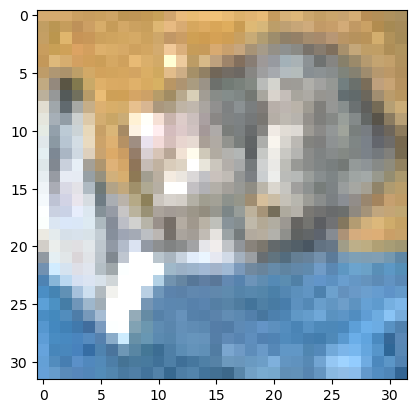

In [15]:
plt.imshow((im[0].numpy().transpose(1,2,0)*255).astype(np.uint8))


In [16]:
for batch in test_loader:
    imk, lb = batch
    break

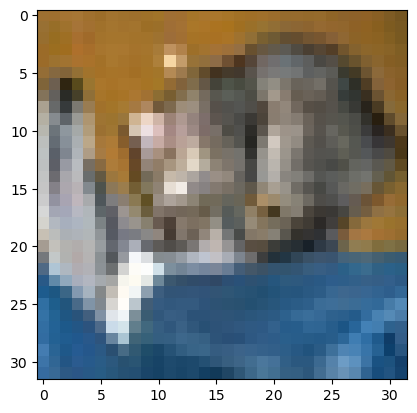

In [17]:
plt.imshow((imk[0].numpy().transpose(1,2,0)*255).astype(np.uint8))


## Build Classifer

In [10]:
sys.path.append('../')
from src.resnet import define_model, get_image_features, feature_dim
from src.build_classifier import get_classifier
from src.train_clf import train

In [6]:
resnet_model = define_model(device='cpu')
resnet_clf = get_classifier(feature_dim, output_classes=10, n_layers=1)

/Users/omermosa/opt/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/omermosa/opt/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [7]:
import torch
loss_fn = torch.nn.CrossEntropyLoss()
optim = torch.optim.Adam(resnet_clf.parameters(), lr=0.001)
device = 'cpu'
n_epochs = 60

In [13]:
losses, accs, val_losses, val_accs = train(resnet_model, resnet_clf, optim=optim, loss_fn=loss_fn,
                                           train_loader=train_loader, val_loader=val_loader,
                                           feature_fn=get_image_features, epochs=2, device=device)

/Users/omermosa/opt/anaconda3/lib/python3.9/site-packages/torch/nn/modules/container.py:204: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


initial loss 2.3011760787599407 and initial accuracy 0.11076831072568893


In [18]:
def get_acc(gt, preds = None):
    if preds is not None: 
        return ((preds.argmax(1)==gt).sum()/len(preds)).cpu().numpy()
        
    
    return ((preds.argmax(1)==gt).sum()/len(preds)).cpu().numpy()
    

def evaluate(emb_model, model):
    eval_acc = []
    eval_losses = []
    for eval_batch in val_loader:
        ims, labels = eval_batch
        ims, labels = ims.to(device), labels.to(device)
        with torch.no_grad():
            features = get_image_features(emb_model, ims).squeeze()
            preds = model(features)
            loss_val = loss_fn(preds, labels.view(-1,))
            val_acc = get_acc(labels.view(-1,), preds)
        
        eval_acc.append(val_acc)
        eval_losses.append(loss_val.item())
    
    return np.mean(eval_losses), np.mean(eval_acc)
            

In [21]:
losses = []
accs = []
val_losses = []
val_accs = []
for ep in range(n_epochs):
    run_loss = 0.
    ep_losses = []
    ep_accs = []

    
    eval_loss, eval_acc = evaluate(resnet_model, resnet_clf) 
    if ep==0:
        print(f'initial loss {eval_loss} and initial accuracy {eval_acc}')
    
    for i, batch in enumerate(train_loader, 0):
        imgs, labels = batch
        imgs, labels = imgs, labels.to(device)
        optim.zero_grad()
        features = get_image_features(resnet_model, imgs).squeeze()
        preds = resnet_clf(features.float())
        # print(preds.argmax(1), labels.view(-1, ))
        loss = loss_fn(preds, labels.view(-1, ))
            
        loss.backward()
        optim.step()
        
        ep_losses.append(loss.item())
        ep_accs.append(get_acc(labels.view(-1,), preds))
        
    ep_loss = np.mean(ep_losses)
    losses.append(ep_loss)
    
    ep_acc = np.mean(ep_accs)
    accs.append(ep_acc)
    
    eval_loss, eval_acc = evaluate(resnet_model, resnet_clf)
    val_losses.append(eval_loss)
    val_accs.append(eval_acc)
    print(f' train loss: {ep_loss}, val loss: {eval_loss}, Train accyracy {ep_acc}, val accuracy {eval_acc} ')

/Users/omermosa/opt/anaconda3/lib/python3.9/site-packages/torch/nn/modules/container.py:204: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


KeyboardInterrupt: 